In [256]:
# %load plt_scat.py
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.stats import gaussian_kde, linregress # new linregress
import matplotlib.font_manager as font_manager

In [77]:
path = '/home/ck/DIR/cornkle/data/SWIFT/sem_data/data/'

#datasets
 
f2 = xr.open_dataset(path+"20190429T0000Z_SWIFT1B_km8p8_ra1t_allmembers.pptn_timerec_WA.nc") # rain
f3 = xr.open_dataset(path+"qrparm.mask_igbp_km8p8_WA.nc", decode_times=False) #  landmask
f4 = xr.open_dataset(path+"20190425T0000Z_SWIFT1B_km8p8_ra1t_allmembers.swflx-net_dim0_WA.nc") #swin
f5  = xr.open_dataset(path+"20190425T0000Z_SWIFT1B_km8p8_ra1t_allmembers.EF_timerec_WA.nc") # EF
f6  = xr.open_dataset(path+"20190425T0000Z_SWIFT1B_km8p8_ra1t_allmembers_SM-SMcrit2_WA.nc", decode_times=False) # SW-SMcrit
flist = [f2,f3,f4,f5,f6]

In [78]:
lon_x = 360

Text(0.5, 1.0, 'Rain test: Member mean input rain')

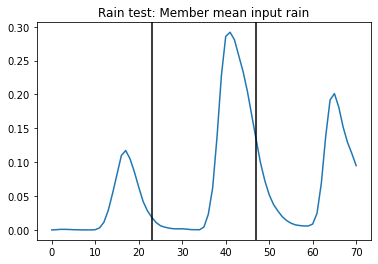

In [264]:
f = plt.figure()
ax = f.add_subplot(111)
ax.plot(f2['stratiform_rainfall_amount'].mean('record').sel(latitude=slice(6,20),longitude=slice(-10+lon_x,10+lon_x)).mean(['latitude', 'longitude']).diff('dim0').squeeze())
ax.axvline(23, color='k')
ax.axvline(47, color='k')
plt.title('Rain test: Member mean input rain')

In [179]:
sw_test = f4["net_down_surface_sw_flux_corrected"].sel(latitude=slice(6,20),longitude=slice(-10+lon_x,10+lon_x)).mean(['record','latitude', 'longitude'])

Text(0.5, 1.0, 'Sw IN TEST - 3-HOURLY')

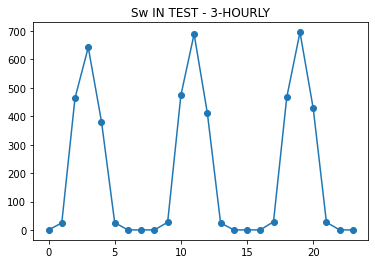

In [265]:
f = plt.figure()
ax = f.add_subplot(111)
ax.plot(sw_test, marker='o')
plt.title('Sw IN TEST - 3-HOURLY')

In [210]:
#pptn = f2["stratiform_rainfall_amount"][:,0:23,:,:]         # OLD CODE - ATTENTION: 0:23 selection only included rainfall up to 22:00
pptn = f2["stratiform_rainfall_amount"][:,0:25,:,:]  # 01UTC - 00UTC
swflx  = f4["net_down_surface_sw_flux_corrected"][:,2,:,:]  # selects sw-in at 0900UTC
 
lat = f2["latitude"][:]
lon = f2["longitude"][:]
 
""" Read LSM for masking out ocean points """
lsm = f3["lsm"][0,0,:,:]
lsmk = lsm.values
print (lsmk.shape )

(202, 368)


In [237]:
swflx_lsm = swflx.where(lsmk==1)  # mask ocean in swin

#sw_mask = swflx_lsm.where(swflx_lsm < 200.) # OLD CODE - ATTENTION: This previous sw_mask picked pixels with LESS THAN 200W/m2 for later analysis!

sw_mask = swflx_lsm >= 200.  # new sw_in mask
 
""" Apply lsm on pptn and  Calculate daily mean precipitation   """
pptn_lsm = pptn.where(lsmk==1)    # mask ocean in precip
pptn_mean = pptn_lsm.mean(dim='dim0') # create 00-24UTC rainfall mean 

""" Mask dry pixels of the WHOLE day and retain the rest  (First mask)"""
# mask1 = pptn_mean < 0.00001  # OLD CODE - ATTENTION: This mask only picks pixels that are dry over the day. We want to REMOVE those. Also: I think we wanted to do the DRY-DAY masking based on GLOB-ENS. CP dry pixel removal is v restrictive

old_mask1 = pptn_mean > 0.00001 # corrected dry day mask version above: this throws out any pixel per member where there is no rain on that day, which however is not the purpose of this filter. Again, this is very restrictive.
mask1 = pptn_mean.any('record') > 0.01 # new dry day mask: pixels are kept if ANY member across the 18 produces accumulated rain >0.01 at a location (i.e. there is minimum potential for rain)
 
""" Mask all the pixels with any rain > 0.25mm until 1000hr"""
old_mask2 = pptn[:,9,:,:] < 0.25 # OLD CODE: creates <0.25 mm rainfall mask UNTIL 0900UTC, changed pptn to pptn_lsm
mask2 = pptn_lsm[:,10,:,:] < 0.25  # corrected morning rain mask, aggregating rain until 10UTC
 
# NOT NEEDED
## Reshape data to single dimension ('singledim')
# flat_dims=('record','longitude', 'latitude')
# drop_dims=['record','longitude', 'latitude']

Text(0.5, 1.0, 'SW mask - nb of retained members')

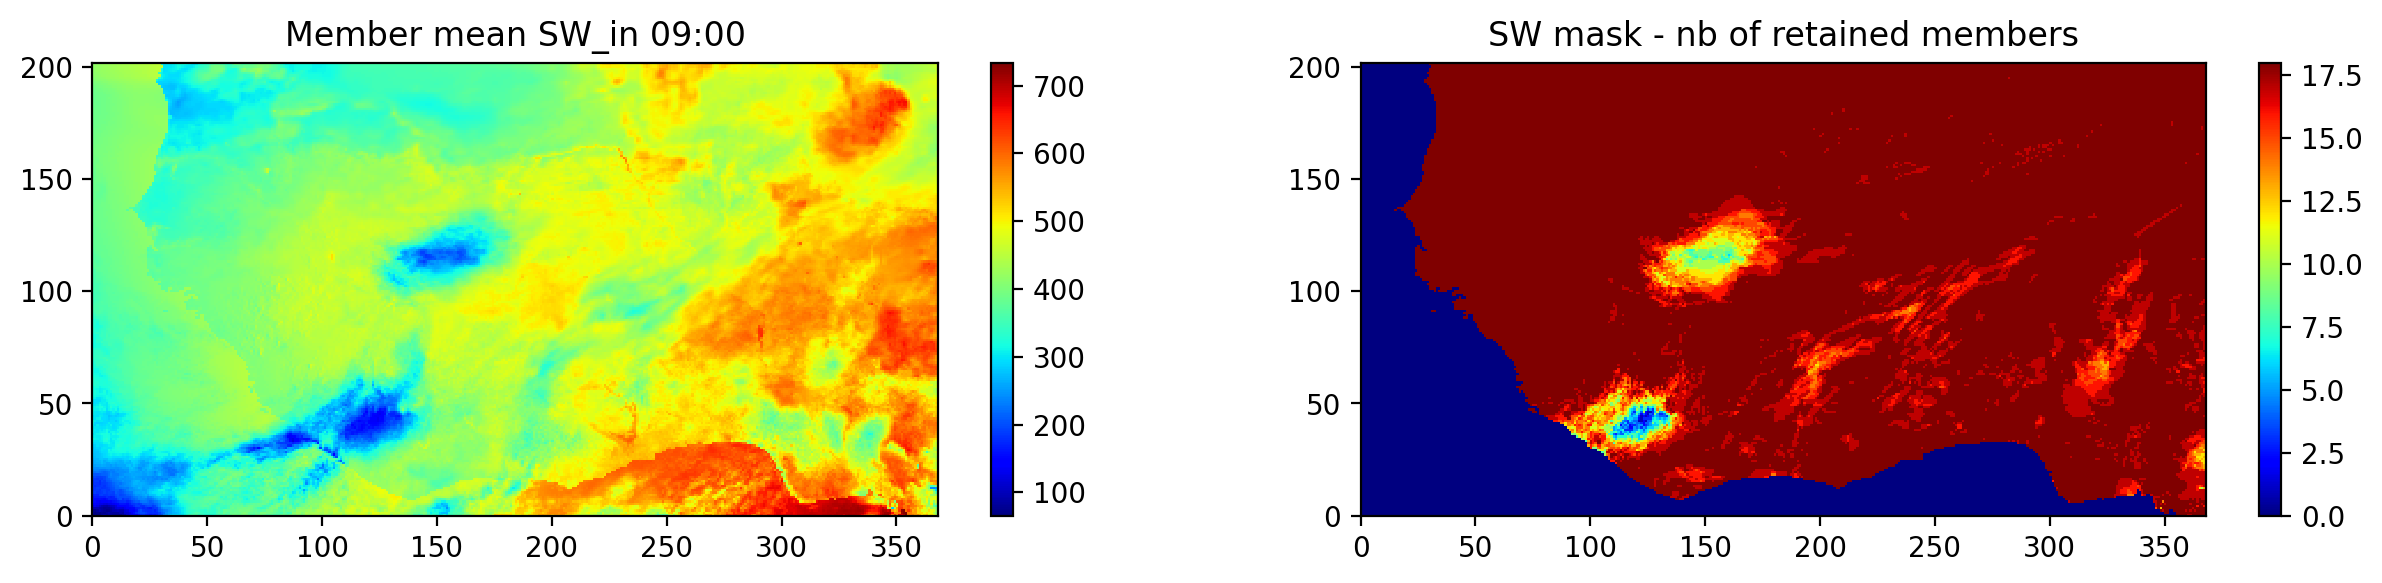

In [238]:
f = plt.figure(figsize=(15,3), dpi=200)
ax = f.add_subplot(121)
plt.pcolormesh(swflx.mean('record'), cmap='jet')
plt.colorbar()
plt.title('Member mean SW_in 09:00')

ax = f.add_subplot(122)
plt.pcolormesh(sw_mask.sum('record'), cmap='jet')
plt.colorbar()
plt.title('SW mask - nb of retained members')

Text(0.5, 1.0, 'Member number difference 0900 to 1000UTC mask')

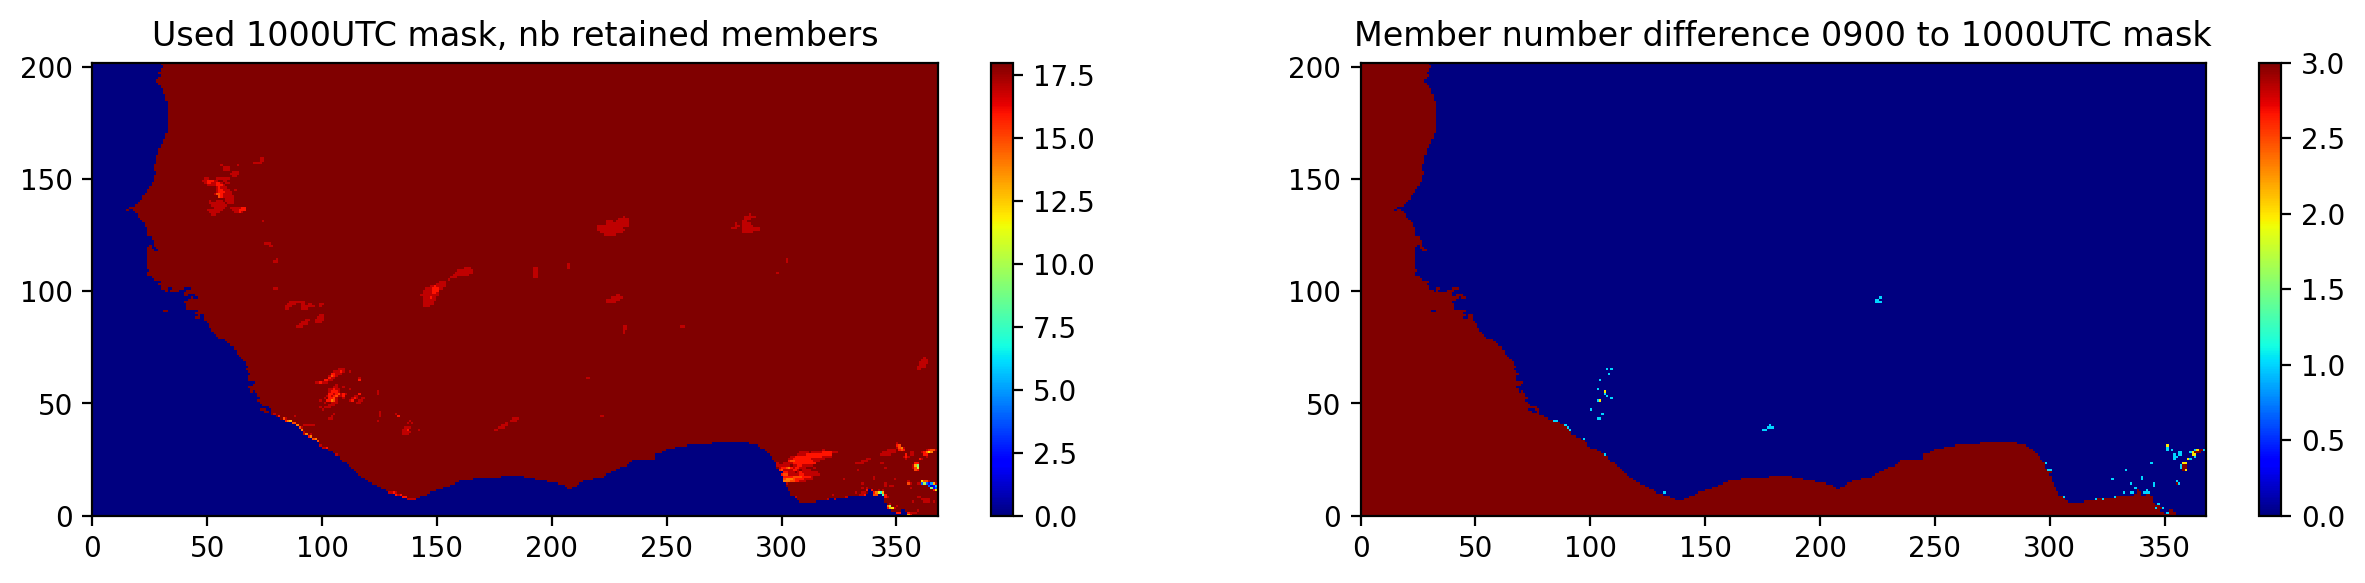

In [239]:
f = plt.figure(figsize=(15,3), dpi=200)
ax = f.add_subplot(121)
plt.pcolormesh(mask2.sum(axis=0), cmap='jet')
plt.colorbar()
plt.title('Used 1000UTC mask, nb retained members')

ax = f.add_subplot(122)
plt.pcolormesh(old_mask2.sum(axis=0)-mask2.sum(axis=0), cmap='jet', vmax=3)
plt.colorbar()
plt.title('Member number difference 0900 to 1000UTC mask')

Text(0.5, 1.0, 'Minimum SW reached (nb members)')

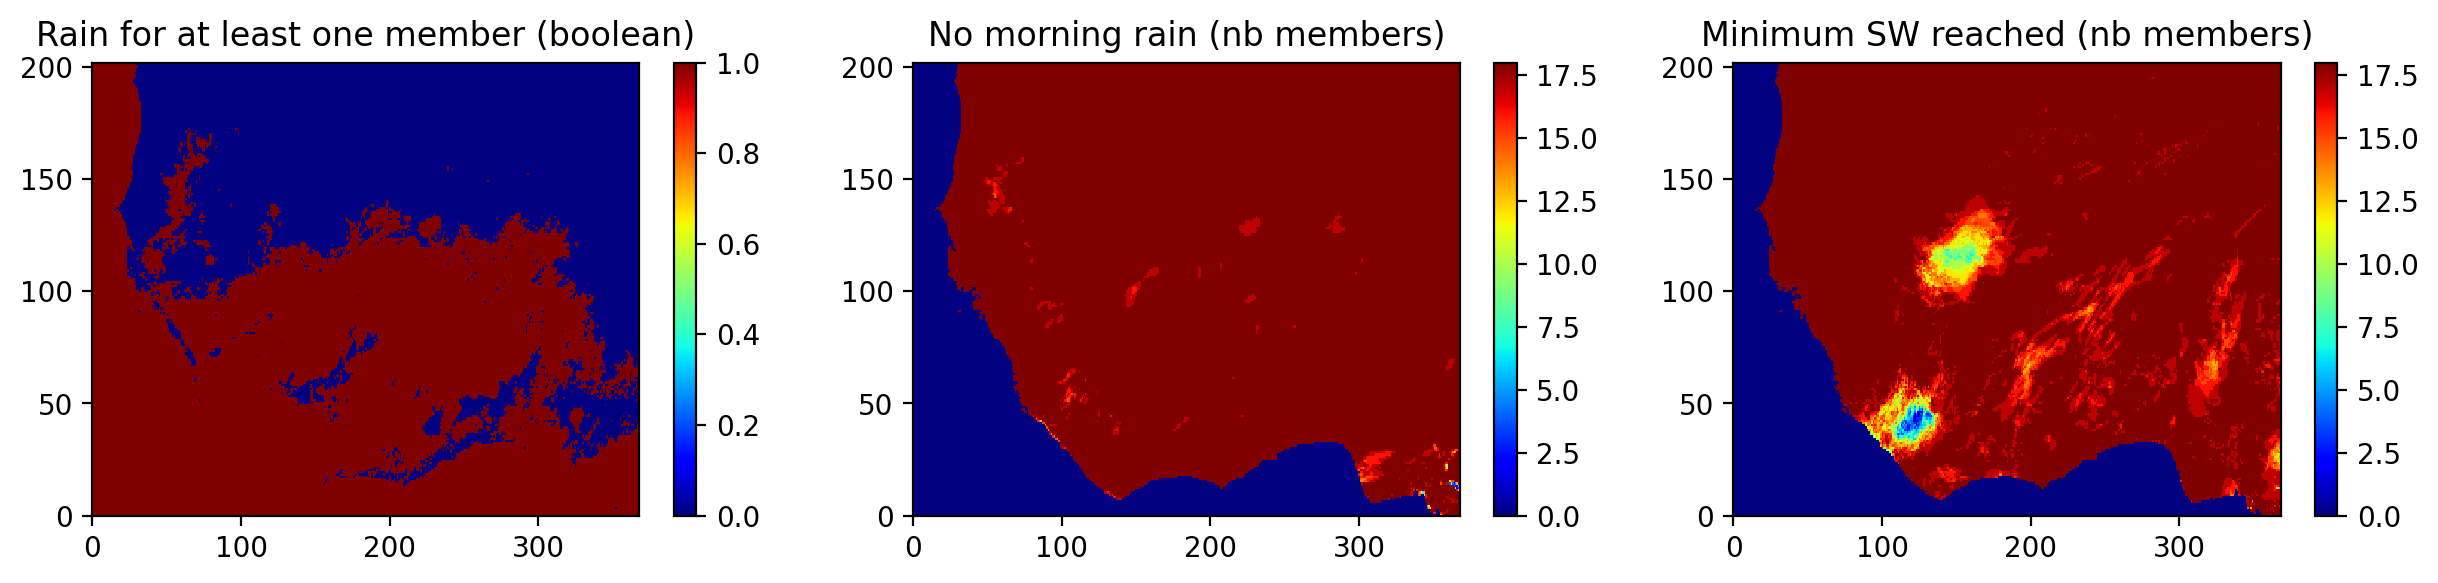

In [240]:
# ALL MASKS
############

f = plt.figure(figsize=(15,3), dpi=200)
ax = f.add_subplot(131)
plt.pcolormesh(mask1,cmap='jet')
plt.colorbar()
plt.title('Rain for at least one member (boolean)')

ax = f.add_subplot(132)
plt.pcolormesh(mask2.sum(axis=0),  cmap='jet')
plt.colorbar()
plt.title('No morning rain (nb members)')

ax = f.add_subplot(133)
plt.pcolormesh(sw_mask.sum(axis=0), cmap='jet')
plt.colorbar()
plt.title('Minimum SW reached (nb members)')

In [241]:
#####   Read EF ############
 
ef  = f5["evap_frac"][2,:,:,:] # picks mean EF 06-0900UTC
 
ef_lsm = ef.where(lsmk==1) # mask ocean

# NOT NEEDED WITH SW-IN FILTER

# m1 = ef_lsm < 1.0
# m2 = ef_lsm > -1.0
# ef_m1 = ef_lsm.where(m1)
# ef_m2 = ef_m1.where(m2)
 
ef_mask1 = ef_lsm.where(mask1) # dry day mask - CHANGED INPUT TO ef_lsm
 
ef_mask2 = ef_mask1.where(mask2) # morning rain 0.25mm mask
ef_mask3 = ef_mask2.where(sw_mask) # sw 200W/m2 mask

In [242]:
""" Calculate the number of members with valida data
on each pixel throughout the domain """
 
ef_count = ef_mask3.count(dim='record')
 
ef_remain = ef_mask3.where(ef_count > 4) # keep only x,y pixels where more than 4 members available, rest NaN
 
""" Calculate ensemble mean """
ef_mean = ef_remain.mean(dim='record') # mean is based on a minimum of 5 members
 
""" Calculate ef anomaly """
#ef_anom=ef_mask3-ef_mean  # OLD CODE - used ef_mask3 where member number is not masked!
ef_anom=ef_remain-ef_mean # new code, use ef_remain

In [243]:
#### NOT NEEDED

# print (ef_anom.shape)
 
# # Reshape data to single dimension ('singledim')
# flat_dims=('record','longitude', 'latitude')
# drop_dims=['record','longitude', 'latitude']
 
# ef_anom_1d = ef_anom.stack(singledim=flat_dims)
# ef_anom_1d  = ef_anom_1d.reset_index('singledim').drop(drop_dims)
 
# # Remove NaN values resulting from da.where criteria applied above
# ef_anom_1d = ef_anom_1d.where(np.isfinite(ef_anom_1d), drop = True)
 
# print (ef_anom_1d.shape)

In [244]:
###################################
## Read SM  #############
 
sm = f6["sm2sm_crit2"][:,0,:,:] # get initial soil moisture field
 
############################################
#####
### Apply EF masks on SM for EF vs SM plots
#####
############################################

# NOT NEEDED: USE EF TO APPLY ALL FILTERS! ALSO ENSURES CONSISTENCY BETWEEN THE TWO VARIABLES

# sm_lsm = sm.where(lsmk==1)


#sm_m1 = sm_lsm.where(m1)
#sm_m2 = sm_m1.where(m2)
 
# # """ Mask dry pixels of the WHOLE day and retain the rest  (First mask)"""
#sm_mask1 = sm_m2.where(mask1)
# sm_mask1 = sm_lsm.where(mask1)
 
# sm_mask2 = sm_mask1.where(mask2)
# sm_mask3 = sm_mask2.where(sw_mask)

sm_remain = sm.where(np.isfinite(ef_remain))   # ATTENTION: simply use ef to mask out SM. There are no SM-specific masks applied, hence this covers all filters.
 
# """ Calculate the number of members with valida data
# on each pixel throughout the domain """
 
# sm_count = sm_mask3.count(dim='record')
 
# sm_remain = sm_mask3.where(sm_count > 4)
 
""" Calculate ensemble mean """
sm_mean = sm_remain.mean(dim='record')
 
""" Calculate anomaly """
sm_anom = sm_remain - sm_mean
 
print (sm_anom.shape)

(18, 202, 368)


Text(0.5, 1.0, 'Valid members EF (min 5 members)')

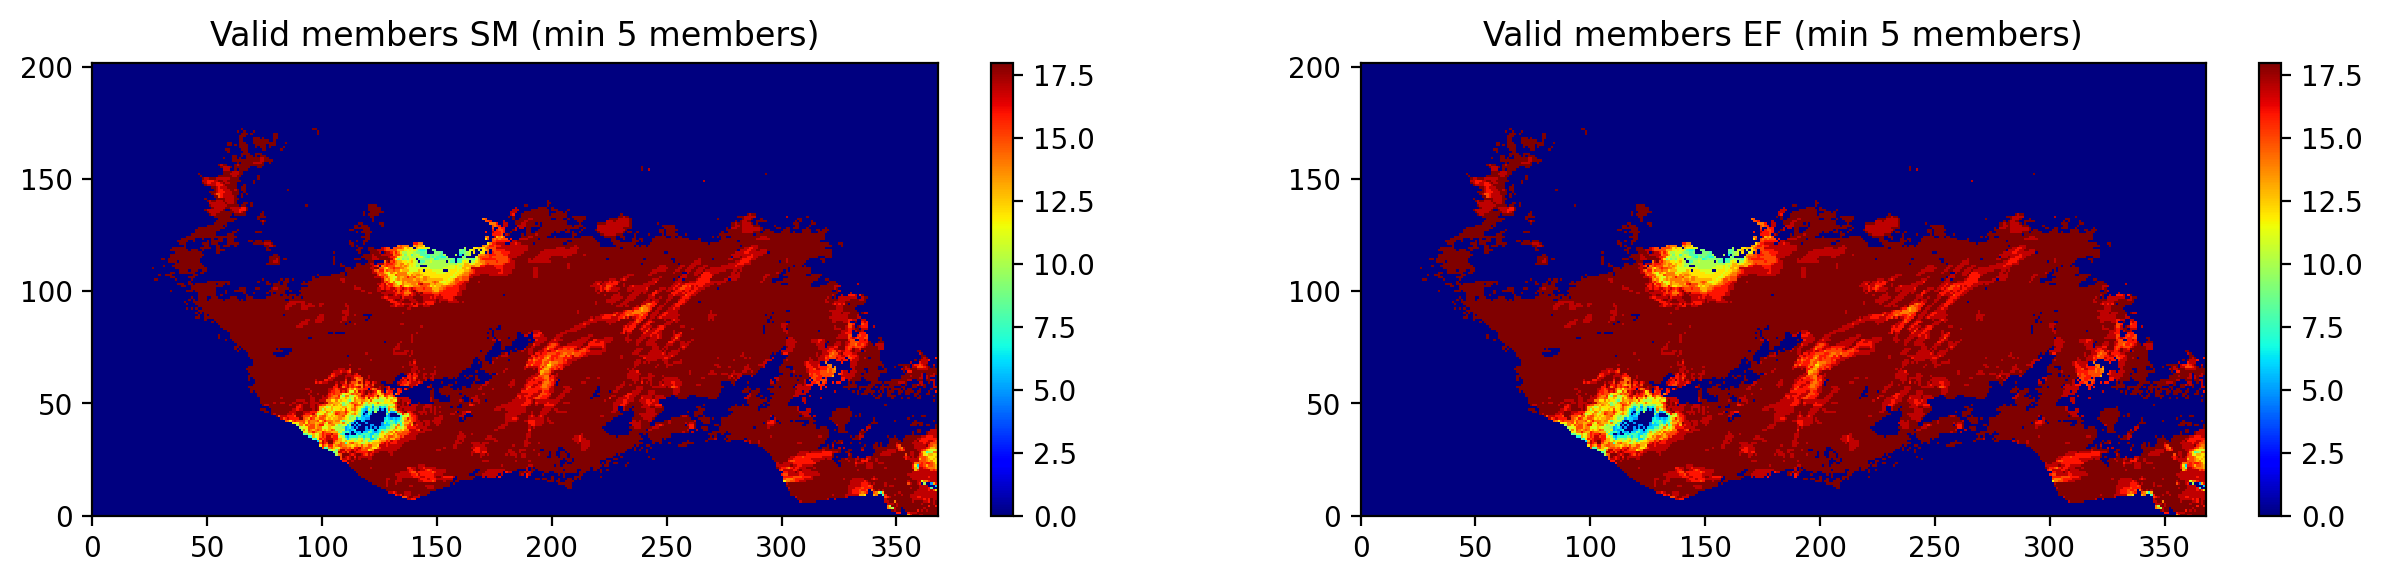

In [245]:
sm_valid = (np.isfinite(sm_anom))
ef_valid = (np.isfinite(ef_anom))

f = plt.figure(figsize=(15,3), dpi=200)
ax = f.add_subplot(121)
plt.pcolormesh(sm_valid.sum('record'), cmap='jet')
plt.colorbar()
plt.title('Valid members SM (min 5 members)')

ax = f.add_subplot(122)
plt.pcolormesh(ef_valid.sum('record'), cmap='jet')
plt.colorbar()
plt.title('Valid members EF (min 5 members)')

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


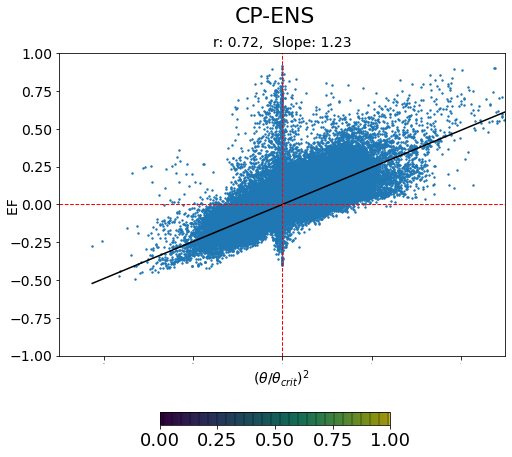

In [259]:

## NOT NEEDED, SEE BELOW

# # Reshape data to single dimension ('singledim')
# sm_anom_1d = sm_anom.stack(singledim=flat_dims)
# sm_anom_1d  = sm_anom_1d.reset_index('singledim').drop(drop_dims)
 
# # Remove NaN values resulting from da.where criteria applied above
# sm_anom_1d = sm_anom_1d.where(np.isfinite(sm_anom_1d), drop = True)
 
# print (sm_anom_1d.shape)
 
def calc_density(v1,v2):
    xy = np.vstack([v1, v2])
    z = gaussian_kde(xy)(xy)
    return z / (z.max() - z.min())

ef_anom_1d = ef_anom.values.flatten()[isfin] # new
sm_anom_1d = sm_anom.values.flatten()[isfin] # new

#""" Fit with polyfit for regression """
# coeff = np.polyfit(sm_anom_1d, ef_anom_1d, 1)
# yp = np.poly1d(coeff)
# slope = coeff[0]


## new: Fit with linregress for regression
slope, inter, rval, pval, serr = linregress(sm_anom_1d, ef_anom_1d)


 
corcoeff = xr.corr(sm_anom, ef_anom) # dim not needed
 
corcoeff = corcoeff.values
 
########Plot the data###########
#################################
fig = plt.figure(figsize=(8, 6))
 
plt.xlabel('$('r'\theta/'r'\theta _{crit})^2$ ', fontsize=14)
 
fig.text(.50, .95, "CP-ENS", ha='center', fontsize=22)
 
ax = fig.add_subplot(211)
ax = plt.axes()
ax.set_xlim(-0.5,0.5)
ax.set_ylim(-1,1,0.1)
plt.xticks(fontsize=0)
plt.yticks(fontsize=14)
 
### to plot
### DENSITY CALCULATION COMMENTED - TAKES LONGER TO RUN. ONLY UNCOMMENT AFTER CHECKS

#density = calc_density(sm_anom_1d,ef_anom_1d)
#cs = plt.scatter(sm_anom_1d,ef_anom_1d, marker = 'o', s = 2, c=density)

cs = plt.scatter(sm_anom_1d,ef_anom_1d, marker = 'o', s = 2)

plt.plot(np.arange(sm_anom_1d.min(), sm_anom_1d.max()), inter +  np.arange(sm_anom_1d.min(), sm_anom_1d.max())*slope, color='k') # NEW 
 
plt.axvline(x=0,linewidth=1,linestyle='--',color='r')
plt.axhline(y=0,linewidth=1,linestyle='--',color='r')
plt.ylabel('EF ', fontsize=14, labelpad=-12)
plt.title(f'r: {corcoeff:.2f},  Slope: {slope:.2f}', fontsize=14)  # uncommented
#plt.title(f'r: {corcoeff:.2f}', fontsize=14)

# add space for colour bar
fig.subplots_adjust(bottom=0.18)
#### add_axes ([left, bottom, width, height])
#### Try a horizontal bar
cbar_ax = fig.add_axes([0.30, 0.02, 0.4, 0.03])
fig.colorbar(cs, cax=cbar_ax, orientation="horizontal", drawedges=True)
 
cbar_ax.tick_params(labelsize='18')
 
#plt.savefig('Fig4_CPscatter_NativeGrid_EFSMOnly_EFmask_NumMask.png', bbox_inches='tight')

plt.show()


In [260]:
pick = (ef_anom > 0.3) & (np.abs(sm_anom) < 0.07)

## COMMENT: The "dry pixel" filter is our most restrictive filter. SW-in would most effectively remove more of the low EF/SM correlation pixels above (right panel). E.g. 300-350 W. Not sure what the problem is though


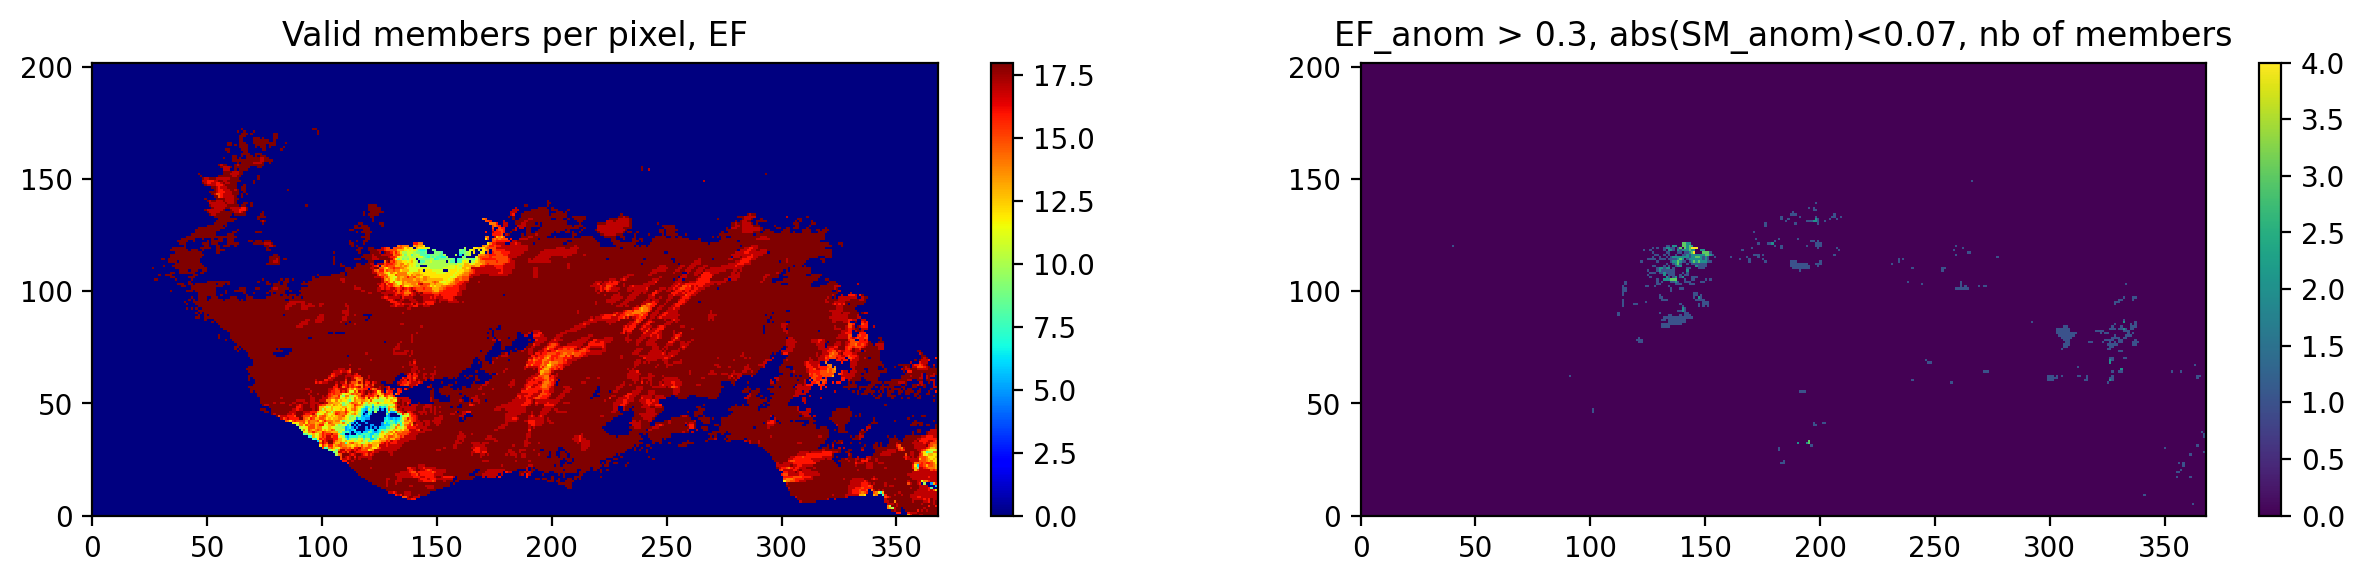

In [263]:

f = plt.figure(figsize=(15,3), dpi=200)
ax = f.add_subplot(121)
plt.pcolormesh(ef_valid.sum('record'), cmap='jet')

plt.colorbar()
plt.title('Valid members per pixel, EF')

ax = f.add_subplot(122)
plt.pcolormesh(np.sum(pick, axis=0), cmap='viridis')
plt.colorbar()
plt.title('EF_anom > 0.3, abs(SM_anom)<0.07, nb of members')
print('## COMMENT: The "dry pixel" filter is our most restrictive filter. SW-in would most effectively remove more of the low EF/SM correlation pixels above (right panel). E.g. 300-350 W. Not sure what the problem is though')